## IMPORTS AND PARAMETERS

In [1]:
from datetime import datetime
import cv2


from data import DataLoader, Process
from models import Models

In [2]:
TRAIN_DATASET_PATH = "./src/train/"
VAL_DATASET_PATH = "./src/val/"

METRICS_PATH = "./training/checkpoint.txt"
OUTPUTS_PATH ="./training/output"

GENERATOR_SAVE_PATH = "./training/generator"
DISCRIMINATOR_SAVE_PATH = "./training/discriminator"

IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNEL = (512, 512,3)
DATA_LENGTH = 14630
EPOCHS = 100
AUTO_SAVE_PERIOT = 5
BATCH_SIZE = 4
BATH_COUNT = int(DATA_LENGTH / BATCH_SIZE)
TRAIN_TOPIC = datetime.now().strftime("%m_%d-%H_%M")
LATENT_DIM = 100  
NUM_CLASSES = 3  


global d_real_losses,d_fake_losses,g_losses 
d_real_losses,d_fake_losses,g_losses = [],[],[]

## DATA

Loading data from:  ./src/train/
Found 14630 files belonging to 3 classes.
Data loaded successfully.
Images scaled to [0,1].
CURRENT DATASET SCALE: True
IMAGE TYPE: float32


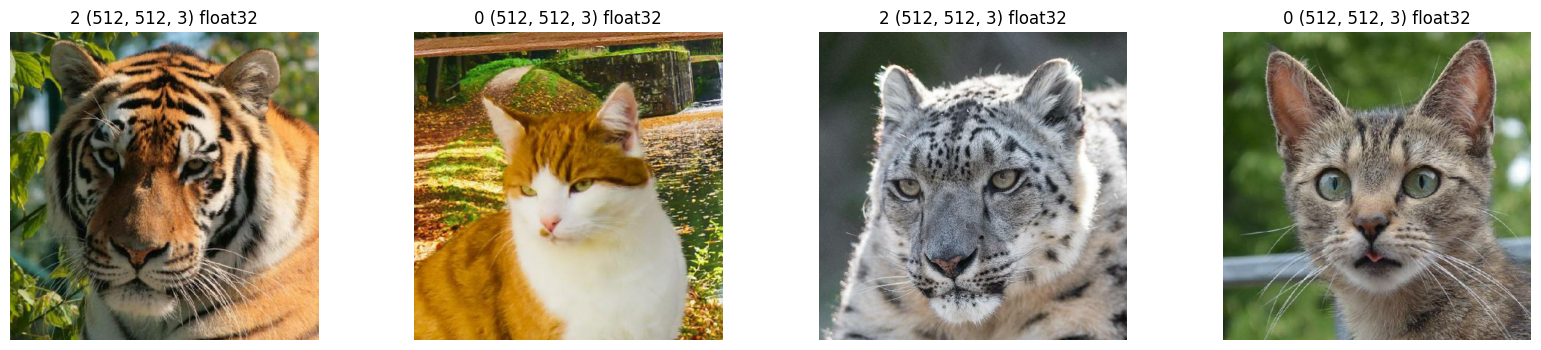

In [3]:
dataloader = DataLoader(batch_size=BATCH_SIZE,image_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
data = dataloader.load_data(TRAIN_DATASET_PATH)
example_imgs,example_lbls = dataloader.show_sample(1)

## MODEL

In [3]:
models = Models()
models.build_models(img_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNEL),latent_dim=LATENT_DIM,num_classes=NUM_CLASSES)
generator = models.generator
discriminator = models.discriminator
gan = models.gan


Model: "gan"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 generator (Functional)         (None, 512, 512, 3)  68837       ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 discriminator (Functional)     (None, 1)            44183       ['generator[0][0]',            

## TRANSFER MODEL

## TRAINING

## TRAIN

## TESTS